# Preamble

In [1]:
%matplotlib notebook

## Notebook parameters

In [2]:
NAME = 'a_5_calculate_auditor_variables'
PROJECT = 'covid-empirical'
PYTHON_VERSION = '3.9'
USER = 'Ties' 
CONDA_ENVIRONMENT = 'covid-empirical'
USE_EXTERNAL_PIPELINE = True

## Run preamble script

In [3]:
%run -i preamble.py 

----------------------------------------------------------------------------------
The following utility functions are loaded and available through `functions.<..>`:
----------------------------------------------------------------------------------

extract_data_edgar_link, fast_load_json, fast_store_json, flatten_multiindex_column, inDB, recreate_edgar_link

----------------------------------------------------------------
The following modules and functions are imported by preamble.py:
----------------------------------------------------------------

copy, delayed, importlib, json, math, np, orjson, os, pd, plt, pqdm_p, pqdm_t, random, re, requests, sys, time, yaml


## Notebook specific imports

In [4]:
from datetime import datetime as dtime
import wrds

---------------
# Retrieve audit analytics data
---------------

In [16]:
## Setting `LOAD_LOCAL` to True will force load the data from drive.
## One has to set this to False when running the code for the first time, after which it will download the data from WRDS
LOAD_LOCAL = True 

current_date = dtime.now().strftime('%m-%d-%Y')
wrds_raw_folder = pipeline / 'store' / 'wrds'
if not wrds_raw_folder.exists(): os.mkdir(wrds_raw_folder)

## Connect to WRDS

In [17]:
## To avoid having to input it all the time, and for security, I store my WRDS username as an environment variable

if not LOAD_LOCAL:
    if 'WRDS_USER' in os.environ:
        WRDS_USER = os.environ['WRDS_USER'] 
    else:
        WRDS_USER = input('What is your WRDS username?')

    ## Connect with WRDS 

    db = wrds.Connection(wrds_username = WRDS_USER)

    # db.create_pgpass_file() # <-- This will create a pgpass file to save your password locally.

## Retrieve Audit Opinions data
https://wrds-www.wharton.upenn.edu/data-dictionary/audit_audit_comp/

The audit opinions dataset contains the audit office city location.

https://wrds-www.wharton.upenn.edu/data-dictionary/audit_audit_comp/auditopin/

### Columns to retrieve:

In [18]:
opinion_columns = [
    'auditor_fkey',
    'auditor_name',
    'auditor_city',
    'auditor_state',
    'auditor_country',
    'fiscal_year_end_op',   ## Full fiscal year end
    'fiscal_year_of_op',    ## Just the year
    'form_fkey',
    'file_date',
    'company_fkey',
    'best_edgar_ticker',
    'matchfy_sum_audfees',   ## Audit fees column 
]

### States to keep as per Choi et al. (2010).

In [19]:
US_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE',
    'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS',
    'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
    'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
    'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
    'WI', 'WY'
]

### Run query

In [20]:
sql_query = f"""
SELECT {','.join(opinion_columns)}
FROM audit_audit_comp.auditopin
WHERE auditor_state IN ({','.join(["'" + x + "'" for x in US_states])})
"""

In [21]:
if not LOAD_LOCAL:
    raw_aa_opinions_df = db.raw_sql(sql_query)
    print(f'''Retrieved a dataset with {len(raw_aa_opinions_df):,} rows.''')

    ## Any columns with dates need to be converted before they can be saved as .dta
    date_col_dict = {
        'fiscal_year_end_op' : '%Y-%m-%d', 
        'file_date' :  '%Y-%m-%d'
    }

    for col, dformat in date_col_dict.items():
        raw_aa_opinions_df[col] = pd.to_datetime(raw_aa_opinions_df[col], format=dformat)


    ## Store raw dataset
    file_name = f'audit_analytics_opinions_{current_date}.dta'
    raw_aa_opinions_df.to_stata(wrds_raw_folder / file_name, write_index = False)

    print(f'''Stored the Audit Opinions dataset with the filename: {file_name}''')

----
## Load local datasets (if requested)

In [22]:
if LOAD_LOCAL:
    raw_aa_opinions_df = pd.read_stata(wrds_raw_folder / 'audit_analytics_opinions_06-03-2022.dta') ## Change this to reflect your file.

## Inspect raw datasets

### Auditor Opinions dataset

In [23]:
raw_aa_opinions_df.head(3).T

,0,1,2
auditor_fkey,5.00,5.00,4.00
auditor_name,Arthur Andersen LLP,Arthur Andersen LLP,KPMG LLP
auditor_city,Philadelphia,Philadelphia,Philadelphia
auditor_state,PA,PA,PA
auditor_country,USA,USA,USA
fiscal_year_end_op,2000-12-30 00:00:00,2001-12-29 00:00:00,2002-12-28 00:00:00
fiscal_year_of_op,"2,000.00","2,001.00","2,002.00"
form_fkey,10-K,10-K405,10-K
file_date,2001-03-26 00:00:00,2002-03-20 00:00:00,2003-03-27 00:00:00
company_fkey,0000000020,0000000020,0000000020


## Create working copy of the datasets

In [24]:
aa_opinions_df = copy.deepcopy(raw_aa_opinions_df)

## Basic data processing steps

### Data types

In [25]:
aa_opinions_df['fiscal_year_of_op'] = aa_opinions_df['fiscal_year_of_op'].astype(int)
aa_opinions_df['auditor_fkey'] = aa_opinions_df['auditor_fkey'].astype(int)

### Rename columns for convenience

In [26]:
aa_opinions_df = aa_opinions_df.rename(columns = {
    'fiscal_year_of_op' : 'fiscal_year'
})

-----
# Generate office level dataset
-----

## Limit sample

### Drop observations that don't have audit fees data

The audit fees dataset appears to lag behind the audit opinions dataset, which results in missing values:    

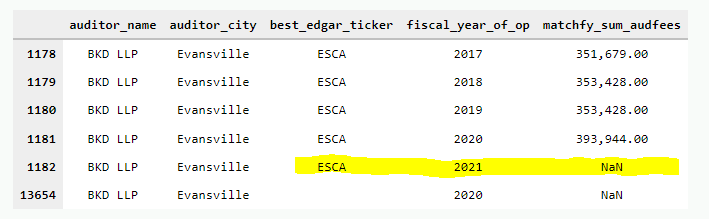

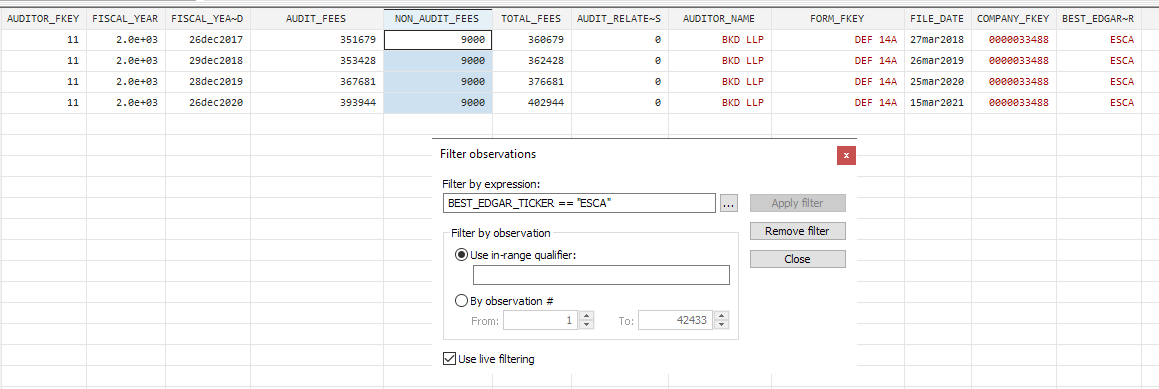

In [27]:
print(f'''Number of obs before drop: {len(aa_opinions_df.index):,}''')
aa_opinions_df = aa_opinions_df.dropna(subset=['company_fkey', 'matchfy_sum_audfees'])
print(f'''Number of obs after drop: {len(aa_opinions_df.index):,}''')

Number of obs before drop: 312,298
Number of obs after drop: 207,127


### Drop observations with missing office city 

In [28]:
print(f'''Number of obs before drop: {len(aa_opinions_df.index):,}''')
aa_opinions_df = aa_opinions_df[(pd.notna(aa_opinions_df['auditor_city'])) & (aa_opinions_df['auditor_city'].str.strip() != '')]
print(f'''Number of obs after drop: {len(aa_opinions_df.index):,}''')

Number of obs before drop: 207,127
Number of obs after drop: 207,120


### Limit to 2018, 2019, 2020

Note, it is not possible (as of 6/1/2022) to calculate the stats for 2021 as the AA coverage is still too low as of June 2022.

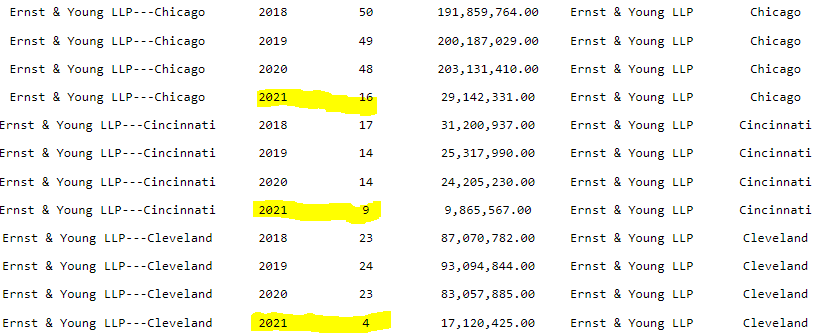

In [29]:
years_to_keep = [2018, 2019, 2020]

In [30]:
aa_opinions_df = aa_opinions_df[aa_opinions_df.fiscal_year.isin(years_to_keep)]

## Add columns

### Big 4 or not

In [31]:
big_4 = [
    'Deloitte & Touche LLP',
    'PricewaterhouseCoopers LLP',
    'Ernst & Young LLP',
    'KPMG LLP'
]

In [32]:
aa_opinions_df['is_big_4'] = aa_opinions_df['auditor_name'].isin(big_4)**1

A few descriptive stats:

In [33]:
col = 'company_fkey'
aa_opinions_df.groupby('is_big_4')[col].count().reset_index().rename(columns={col : 'Number of opinions:'})

,is_big_4,Number of opinions:
0,0,9781
1,1,14300


In [34]:
print('The top 10 biggest audit firms in the sample:')
aa_opinions_df.auditor_name.value_counts().head(10)

The top 10 biggest audit firms in the sample:


PricewaterhouseCoopers LLP    4028
Ernst & Young LLP             3995
Deloitte & Touche LLP         3527
KPMG LLP                      2750
BDO USA LLP                    727
Grant Thornton LLP             712
Marcum LLP                     658
RSM US LLP                     469
Cohen & Company Ltd (OH)       465
WithumSmith + Brown PC         316
Name: auditor_name, dtype: int64

## Collapse to the audit office level

### Create unique ID for audit office at the city level

In [35]:
aa_opinions_df['auditor_office_id'] = aa_opinions_df['auditor_name'] + '---' + aa_opinions_df['auditor_city']

print(f'''Number of unique auditors: {len(aa_opinions_df['auditor_name'].unique()):,}''')
print(f'''Number of unique auditor + office city combinations: {len(aa_opinions_df['auditor_office_id'].unique()):,}''')

Number of unique auditors: 291
Number of unique auditor + office city combinations: 940


In [36]:
print('The top 10 biggest audit offices in the sample:')
aa_opinions_df.auditor_office_id.value_counts().head(10)

The top 10 biggest audit offices in the sample:


Deloitte & Touche LLP---Boston               862
Ernst & Young LLP---Boston                   726
PricewaterhouseCoopers LLP---Boston          593
PricewaterhouseCoopers LLP---New York        557
Ernst & Young LLP---New York                 544
Marcum LLP---New York                        396
PricewaterhouseCoopers LLP---Philadelphia    392
PricewaterhouseCoopers LLP---Baltimore       368
KPMG LLP---New York                          341
KPMG LLP---Chicago                           329
Name: auditor_office_id, dtype: int64

### Collapse to audit office level

In [37]:
office_df = aa_opinions_df.groupby(['auditor_office_id', 'fiscal_year'], as_index=False).agg({
    'company_fkey' : 'count', 
    'matchfy_sum_audfees' : 'sum',
    'is_big_4' : 'first'
})

### Clean up dataset

In [38]:
office_df['auditor_name'] = office_df.auditor_office_id.apply(lambda x: x.split('---')[0])
office_df['auditor_office_city'] = office_df.auditor_office_id.apply(lambda x: x.split('---')[1])

In [39]:
office_df = office_df.sort_values(['auditor_name', 'auditor_office_city', 'fiscal_year'])

In [40]:
office_df = office_df.rename(columns={
    'company_fkey' : 'num_clients',
    'matchfy_sum_audfees' : 'total_audit_fees'
})

### Inspect office dataset

Show random sample:

In [41]:
office_df.sample(5)

,auditor_office_id,fiscal_year,num_clients,total_audit_fees,is_big_4,auditor_name,auditor_office_city
2311,Whitley Penn LLP---Plano,2018,3,"510,570.00",0,Whitley Penn LLP,Plano
581,Deloitte & Touche LLP---Grand Rapids,2019,4,"4,736,674.00",1,Deloitte & Touche LLP,Grand Rapids
392,Citrin Cooperman & Company LLP---New York,2019,1,"80,175.00",0,Citrin Cooperman & Company LLP,New York
932,Ernst & Young LLP---Saint Louis,2020,9,"31,569,388.00",1,Ernst & Young LLP,Saint Louis
1442,KPMG LLP---Tampa,2019,7,"18,970,128.00",1,KPMG LLP,Tampa


Show a random slice that keeps time series order:

In [42]:
num_obs = 10
rand_int = random.randint(0, len(office_df)-num_obs)
print(rand_int)
office_df.iloc[rand_int:rand_int+num_obs]

421


,auditor_office_id,fiscal_year,num_clients,total_audit_fees,is_big_4,auditor_name,auditor_office_city
421,CohnReznick LLP---Jericho,2020,7,"1,295,420.00",0,CohnReznick LLP,Jericho
422,CohnReznick LLP---New York,2018,5,"4,165,340.00",0,CohnReznick LLP,New York
423,CohnReznick LLP---New York,2019,4,"2,045,713.00",0,CohnReznick LLP,New York
424,CohnReznick LLP---New York,2020,4,"1,176,400.00",0,CohnReznick LLP,New York
425,CohnReznick LLP---Roseland,2018,5,"1,818,979.00",0,CohnReznick LLP,Roseland
426,CohnReznick LLP---Roseland,2019,8,"2,557,494.00",0,CohnReznick LLP,Roseland
427,CohnReznick LLP---Roseland,2020,2,"407,752.00",0,CohnReznick LLP,Roseland
428,CohnReznick LLP---Tysons,2018,3,"538,694.00",0,CohnReznick LLP,Tysons
429,CohnReznick LLP---Tysons,2019,3,"585,824.00",0,CohnReznick LLP,Tysons
430,CohnReznick LLP---Tysons,2020,5,"2,438,333.00",0,CohnReznick LLP,Tysons


## Add "large" vs. "small indicators"

Choi does it based on the median.   
Beck does it within audit firm based on the 10% cut-off

### Choi et al. version 

In [43]:
median_cutoff_dict = office_df.groupby('fiscal_year').median().to_dict()
median_cutoff_dict

{'num_clients': {2018: 3.0, 2019: 3.0, 2020: 3.0},
 'total_audit_fees': {2018: 1268000.0, 2019: 1364215.5, 2020: 1629331.5},
 'is_big_4': {2018: 0.0, 2019: 0.0, 2020: 0.0}}

In [44]:
tmp = office_df.apply(lambda row: row['num_clients'] > median_cutoff_dict['num_clients'][row['fiscal_year']], axis = 1) ** 1
office_df['choi_large_office_by_clients'] = tmp
office_df['choi_large_office_by_clients'].value_counts()

0    1218
1    1167
Name: choi_large_office_by_clients, dtype: int64

In [45]:
tmp = office_df.apply(lambda row: row['total_audit_fees'] > median_cutoff_dict['total_audit_fees'][row['fiscal_year']], axis = 1) ** 1
office_df['choi_large_office_by_fees'] = tmp

office_df['choi_large_office_by_fees'].value_counts()

0    1193
1    1192
Name: choi_large_office_by_fees, dtype: int64

### Beck et al. version

As described in Footnote 1:
> Throughout the paper and in our empirical analysis we refer to offices in the top decile of total audit fees within each Big 4 firm as “large” and to all other offices as “small.”

This only applies to big 4 firms, so I set it to missing for non-big 4!

In [46]:
big_4_df = office_df[office_df.is_big_4 == 1].groupby(['auditor_name', 'auditor_office_city'])[['total_audit_fees']].mean().reset_index()
big_4_df.head()

,auditor_name,auditor_office_city,total_audit_fees
0,Deloitte & Touche LLP,Atlanta,"78,131,962.67"
1,Deloitte & Touche LLP,Austin,"2,254,150.67"
2,Deloitte & Touche LLP,Baltimore,"4,186,566.67"
3,Deloitte & Touche LLP,Birmingham,"5,187,753.33"
4,Deloitte & Touche LLP,Boca Raton,"21,307,999.67"


In [47]:
big_4_df = big_4_df.sort_values(['auditor_name', 'total_audit_fees'], ascending=False)

In [48]:
big4_large_cutoffs = big_4_df.groupby('auditor_name')['total_audit_fees'].quantile(0.9).to_dict()
for office, amount in big4_large_cutoffs.items():
    print(f'''{office : >30} - 10% cut-off -> ${amount:,.0f}''')

         Deloitte & Touche LLP - 10% cut-off -> $87,270,194
             Ernst & Young LLP - 10% cut-off -> $128,766,903
                      KPMG LLP - 10% cut-off -> $94,584,846
    PricewaterhouseCoopers LLP - 10% cut-off -> $137,502,932


In [49]:
tmp = big_4_df.apply(lambda row: row['total_audit_fees'] >= big4_large_cutoffs[row['auditor_name']], axis=1) ** 1
big_4_df['beck_large_office'] = tmp

In [50]:
big_4_df.sample(10)

,auditor_name,auditor_office_city,total_audit_fees,beck_large_office
196,PricewaterhouseCoopers LLP,Atlanta,"57,738,648.67",0
181,KPMG LLP,Richmond,"31,705,494.33",0
205,PricewaterhouseCoopers LLP,Cleveland,"24,943,598.00",0
201,PricewaterhouseCoopers LLP,Buffalo,"7,795,858.33",0
133,KPMG LLP,Boise,"4,299,819.67",0
178,KPMG LLP,Portland,"15,753,021.00",0
251,PricewaterhouseCoopers LLP,Seattle,"39,653,657.00",0
20,Deloitte & Touche LLP,Hartford,"26,917,787.00",0
37,Deloitte & Touche LLP,New York,"506,370,223.67",1
231,PricewaterhouseCoopers LLP,Minneapolis,"80,489,448.00",0


In [51]:
office_df = pd.merge(office_df, big_4_df.drop('total_audit_fees', axis=1), on=['auditor_name', 'auditor_office_city'], how='left')

In [52]:
office_df['beck_large_office'].value_counts(dropna=False)

NaN     1643
0.00     661
1.00      81
Name: beck_large_office, dtype: int64

-----
# Generate filing level dataset
-----

## Create new dataset

Note, we only keep 10-Ks as the other filings never show up in our main sample.

In [53]:
filing_level_df = copy.deepcopy(aa_opinions_df)

In [54]:
filing_level_df = filing_level_df[aa_opinions_df.form_fkey == '10-K']

## Merge office level variables into the filing level dataset

In [55]:
office_df_to_merge = office_df.drop(['is_big_4', 'auditor_office_city', 'auditor_name'], axis=1)
merge_df = pd.merge(filing_level_df, office_df_to_merge , on=['auditor_office_id', 'fiscal_year'], how='left')

assert len(merge_df) == len(filing_level_df), 'Warning, the number of observations changed whereas it should not!'
filing_level_df = merge_df

## Basic cleaning for convenience

### Rename columns

In [56]:
filing_level_df = filing_level_df.rename(columns = {
    'matchfy_sum_audfees' : 'filing_audit_fees',
    'best_edgar_ticker' : 'ticker',
    'fiscal_year_end_op' : 'fiscal_year_end'
})

## Description of audit variables:

Choi et al. 2010 measures:

- `choi_ofsize1` - the number of clients of the office minus one  (i.e., `num_clients - 1`)
- `choi_ofsize2` - the sum of audit fees of all clients - minus the audit fee of specific client (i.e., `total_audit_fees - filing_audit_fees `)
- `choi_large_office_by_clients` - 1 if above the median number of `num_clients`, by year; 0 otherwise
- `choi_large_office_by_fees` - 1 if above the median sum of `total_audit_fees`, by year; 0 otherwise

Beck, Gunn, Hallman (2022, JAE) measures:

- `beck_ln_office_size` - natural log of total audit fees genereated during the current year by the opinion signing audit office
- `beck_large_office` - An indicator variable equal to 1 if the client is audited by a large audit office, defined as an office in the top ten percent of average audit fees within each audit firm during our sample period; 0 otherwise

Ege and Stuber (2022, JAE) measures:

- `ege_ln_office_size` - natural log of 1 plus number of audit clients of office j in year t.

Other measures:

- `is_big_4` - 1 if the audit firm is Big 4, 0 otherwise. 
- `ln_audit_fees` - The natural log of audit fees paid by the client in the current year.
- `auditor_tenure` - TBD
- `new_auditor` - 1 if different auditor relative to last year; 0 otherwise
- `new_auditor_office` - 1 if different auditor office relative to last year; 0 otherwise

## Choi et al. measures

In [57]:
filing_level_df['choi_ofsize1'] = filing_level_df['num_clients'] - 1
filing_level_df['choi_ofsize2'] = filing_level_df['total_audit_fees'] - filing_level_df['filing_audit_fees']

## Beck et al. measures

In [58]:
filing_level_df['beck_ln_office_size'] = np.log(filing_level_df['total_audit_fees'] + 1) ## Added +1 to avoid inf

## Ege et al. measures

In [59]:
filing_level_df['ege_ln_office_size'] = np.log(filing_level_df['num_clients'] + 1) ## Added +1 to avoid inf

## Custom measures

In [60]:
filing_level_df['ln_audit_fees'] = np.log(filing_level_df['filing_audit_fees'] + 1)

### Auditor tenure

In [61]:
tenure_df = raw_aa_opinions_df.copy()
tenure_df = tenure_df.rename(columns={'fiscal_year_end_op': 'fiscal_year_end'})
tenure_df = tenure_df.sort_values(['company_fkey', 'fiscal_year_end'])
tenure_df['prev_auditor'] = tenure_df.groupby('company_fkey')['auditor_name'].shift(1)

tenure_df = tenure_df[tenure_df.form_fkey == '10-K']

Create an index that shows a company + auditor "episode":

In [62]:
episode_tracker = 0
prev_comp = ''
episode_list = []
for i, row in tqdm(tenure_df.iterrows(), total=len(tenure_df.index)):
    if row['company_fkey'] != prev_comp:
        prev_comp = row['company_fkey']
        
    if row['auditor_name'] == row['prev_auditor']:
        episode_list.append(episode_tracker)
        
    else:
        episode_tracker += 1
        episode_list.append(episode_tracker)

  0%|          | 0/145772 [00:00<?, ?it/s]

In [63]:
tenure_df['episode_id'] = episode_list

Calculate tenure

In [64]:
tenure_df['auditor_tenure'] = tenure_df.groupby('episode_id').cumcount() + 1

Inspect to make sure it worked

In [65]:
num_obs = 15
#rand_int = random.randint(0, len(tenure_df)-num_obs)
rand_int = 64537 ## This index shows an auditor change. 
print(rand_int)
col_to_show = ['company_fkey', 'fiscal_year_end', 'auditor_fkey', 'auditor_name', 'prev_auditor', 'episode_id', 'auditor_tenure']
tenure_df.iloc[rand_int:rand_int+num_obs][col_to_show]

64537


,company_fkey,fiscal_year_end,auditor_fkey,auditor_name,prev_auditor,episode_id,auditor_tenure
125390,0000943897,2006-10-01,3.00,Deloitte & Touche LLP,Deloitte & Touche LLP,9211,10
125391,0000943897,2007-09-30,3.00,Deloitte & Touche LLP,Deloitte & Touche LLP,9211,11
125392,0000943897,2008-09-28,3.00,Deloitte & Touche LLP,Deloitte & Touche LLP,9211,12
125393,0000943897,2009-09-27,3.00,Deloitte & Touche LLP,Deloitte & Touche LLP,9211,13
125394,0000943904,2000-03-31,7.00,BDO Seidman LLP,NaN,9212,1
125395,0000943904,2001-03-31,7.00,BDO Seidman LLP,BDO Seidman LLP,9212,2
125396,0000943904,2002-03-31,7.00,BDO Seidman LLP,BDO Seidman LLP,9212,3
125397,0000943904,2003-03-31,7.00,BDO Seidman LLP,BDO Seidman LLP,9212,4
125398,0000943904,2004-03-31,"1,798.00",Reznick Group PC,BDO Seidman LLP,9213,1
125399,0000943904,2005-03-31,"1,798.00",Reznick Group PC,Reznick Group PC,9213,2


### Multiple auditor issue

A filing can have more than one auditor in very rare cases. I drop these from the sample

In [66]:
problem_df = tenure_df.groupby(['company_fkey', 'fiscal_year_end']).size().sort_values()
problem_df.value_counts()

1    145716
2        28
dtype: int64

In [67]:
problem_df = problem_df[problem_df > 1].reset_index().drop(0, axis=1)
problem_df['bad'] = True

problem_df

,company_fkey,fiscal_year_end,bad
0,0000744218,2007-12-31,True
1,0001108967,2013-12-31,True
2,0000880259,1999-12-31,True
3,0000715579,2012-12-31,True
4,0001085706,2012-12-31,True
5,0001013455,1999-12-31,True
6,0001506401,2014-12-31,True
7,0001427352,2008-12-31,True
8,0001326396,2009-12-31,True
9,0000868271,2013-12-31,True


In [68]:
tenure_df = pd.merge(tenure_df, problem_df, on=['company_fkey', 'fiscal_year_end'], how='left')

In [69]:
tenure_df['bad'].value_counts()

True    56
Name: bad, dtype: int64

In [70]:
tenure_df = tenure_df[pd.isna(tenure_df['bad'])]
tenure_df = tenure_df.drop('bad', axis=1)

Add tenure variable back to the dataset

In [71]:
tenure_df_slim = tenure_df[['company_fkey', 'fiscal_year_end', 'auditor_tenure']].drop_duplicates()

In [72]:
merge_df = pd.merge(filing_level_df, tenure_df_slim , on=['company_fkey', 'fiscal_year_end'], how='left')
assert len(merge_df) == len(filing_level_df), 'Warning, the number of observations changed whereas it should not!'
filing_level_df = merge_df

### New auditor variables

Auditor level

In [73]:
filing_level_df['new_auditor'] = (filing_level_df['auditor_tenure'] == 1)**1

Office level

In [74]:
filing_level_df = filing_level_df.sort_values(['company_fkey', 'fiscal_year_end'])

filing_level_df['prev_auditor_office_id'] = filing_level_df.groupby('company_fkey')['auditor_office_id'].shift(1)

filing_level_df['new_auditor_office'] = ((filing_level_df['auditor_office_id'] != filing_level_df['prev_auditor_office_id']) & pd.notna(filing_level_df['prev_auditor_office_id']))**1
filing_level_df['new_auditor_office'] = filing_level_df.apply(lambda x: 1 if x['new_auditor'] == 1 else x['new_auditor_office'], axis=1)

In [75]:
filing_level_df = filing_level_df.drop('prev_auditor_office_id', axis=1, errors='ignore')

-----
## Summary statistics

In [76]:
filing_level_df[[
    'choi_ofsize1', 'choi_ofsize2', 'choi_large_office_by_clients', 'choi_large_office_by_fees',
    'beck_ln_office_size', 'beck_large_office',
    'ege_ln_office_size',
    'is_big_4', 'ln_audit_fees', 'auditor_tenure', 'new_auditor', 'new_auditor_office'
]].describe().T

,count,mean,std,min,25%,50%,75%,max
choi_ofsize1,"16,446.00",39.38,55.85,0.00,6.00,17.00,46.00,288.00
choi_ofsize2,"16,446.00","64,647,373.39","110,166,000.70",0.00,"1,913,216.75","13,310,547.50","87,387,275.00","677,156,037.00"
choi_large_office_by_clients,"16,446.00",0.88,0.32,0.00,1.00,1.00,1.00,1.00
choi_large_office_by_fees,"16,446.00",0.80,0.40,0.00,1.00,1.00,1.00,1.00
beck_ln_office_size,"16,446.00",16.36,2.25,8.16,14.63,16.56,18.34,20.33
beck_large_office,"8,732.00",0.39,0.49,0.00,0.00,0.00,1.00,1.00
ege_ln_office_size,"16,446.00",2.99,1.22,0.69,2.08,2.94,3.87,5.67
is_big_4,"16,446.00",0.53,0.50,0.00,0.00,1.00,1.00,1.00
ln_audit_fees,"16,446.00",13.26,1.86,0.00,12.02,13.53,14.58,18.14
auditor_tenure,"16,446.00",10.33,8.48,1.00,3.00,8.00,17.00,65.00


In [77]:
filing_level_df[filing_level_df.fiscal_year == 2020][[
    'choi_ofsize1', 'choi_ofsize2', 'choi_large_office_by_clients', 'choi_large_office_by_fees',
    'beck_ln_office_size', 'beck_large_office',
    'ege_ln_office_size',
    'is_big_4', 'ln_audit_fees', 'auditor_tenure', 'new_auditor', 'new_auditor_office'
]].describe().T

,count,mean,std,min,25%,50%,75%,max
choi_ofsize1,"5,385.00",40.66,58.92,0.00,6.00,17.00,47.00,284.00
choi_ofsize2,"5,385.00","66,193,721.26","111,091,079.79",0.00,"1,974,613.00","15,357,876.00","90,827,308.00","670,317,301.00"
choi_large_office_by_clients,"5,385.00",0.88,0.32,0.00,1.00,1.00,1.00,1.00
choi_large_office_by_fees,"5,385.00",0.80,0.40,0.00,1.00,1.00,1.00,1.00
beck_ln_office_size,"5,385.00",16.43,2.23,8.34,14.75,16.69,18.34,20.32
beck_large_office,"2,912.00",0.40,0.49,0.00,0.00,0.00,1.00,1.00
ege_ln_office_size,"5,385.00",2.99,1.24,0.69,2.08,2.94,3.89,5.66
is_big_4,"5,385.00",0.54,0.50,0.00,0.00,1.00,1.00,1.00
ln_audit_fees,"5,385.00",13.32,1.82,0.00,12.13,13.59,14.60,18.13
auditor_tenure,"5,385.00",10.65,8.69,1.00,3.00,8.00,17.00,65.00


## Store dataset

### Stata

In [78]:
filing_level_df.to_stata(pipeline / 'out' / 'auditor_variables.dta', write_index = False)

### Excel

In [6]:
filing_level_df.to_excel(pipeline / 'out' / 'auditor_variables.xlsx', index=False)